In [1]:
# Step 1: Install gdown
!pip install -q gdown

# Step 2: Download the ZIP file from your Google Drive link
!gdown --id 1GsnkaeJkd7Fx3mwuVcN3vhvLscbVW3rg -O Main.zip

# Step 3: Unzip into /content/dataset
!unzip -q Main.zip -d /content/dataset

# Step 4: List extracted folders to verify
!ls /content/dataset

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1GsnkaeJkd7Fx3mwuVcN3vhvLscbVW3rg
From (redirected): https://drive.google.com/uc?id=1GsnkaeJkd7Fx3mwuVcN3vhvLscbVW3rg&confirm=t&uuid=e59a731b-dd1d-4428-a34a-4cf5164faf0c
To: /content/Main.zip
100% 5.10G/5.10G [00:35<00:00, 145MB/s]
Main


In [2]:
import pandas as pd
import matplotlib.pyplot as plt

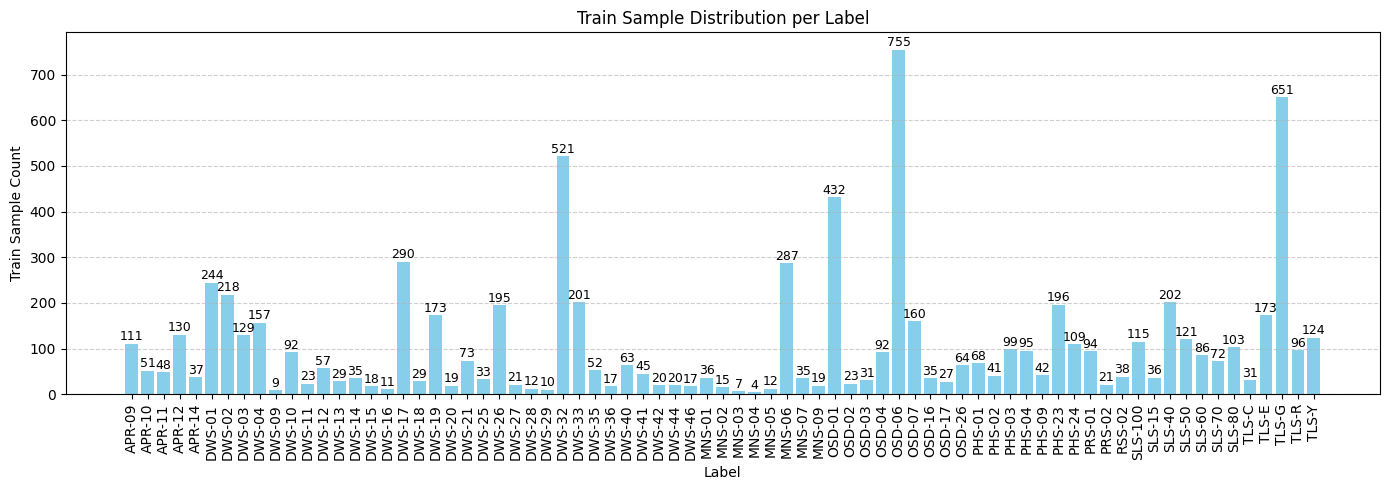

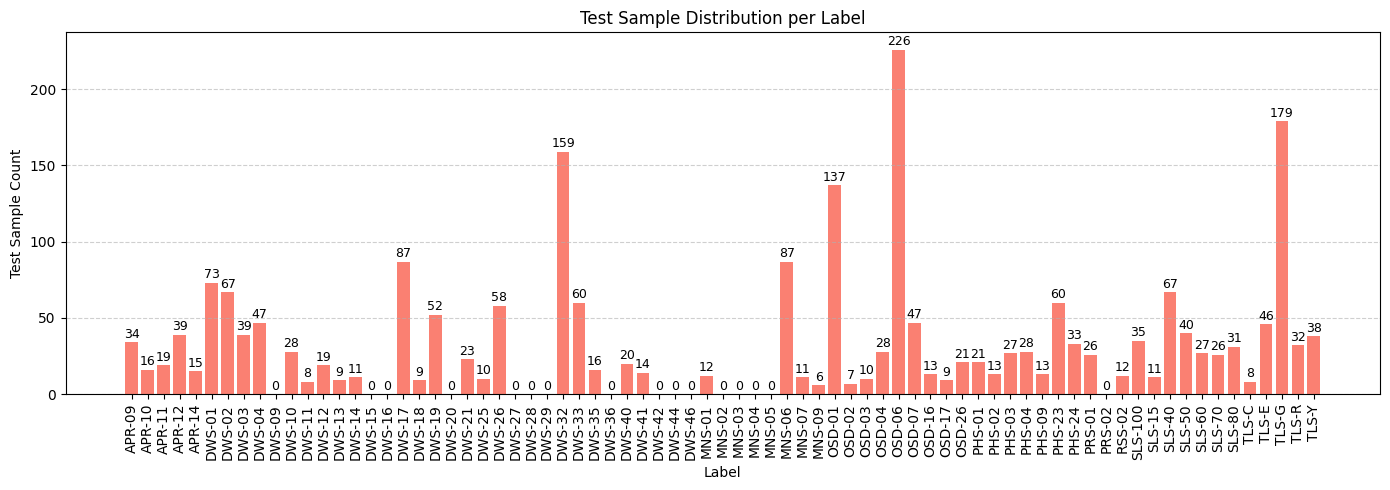

In [3]:
# Load and clean the data
df = pd.read_csv('/content/dataset/Main/label_frequencies.xlsx - Label Frequencies.csv')
df = df.drop(columns=['Total'])
df = df[df['Label'].str.lower() != 'total']

# --- Plot Train Distribution ---
plt.figure(figsize=(14, 5))
bars = plt.bar(df['Label'], df['Train'], color='skyblue')
plt.title('Train Sample Distribution per Label')
plt.xlabel('Label')
plt.ylabel('Train Sample Count')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Add value labels on top
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1, str(height), ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# --- Plot Test Distribution ---
plt.figure(figsize=(14, 5))
bars = plt.bar(df['Label'], df['Test'], color='salmon')
plt.title('Test Sample Distribution per Label')
plt.xlabel('Label')
plt.ylabel('Test Sample Count')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Add value labels on top
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1, str(height), ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

In [4]:
!ls /content/dataset/Main

'label_frequencies.xlsx - Label Frequencies.csv'   sample   test   train


In [5]:
import os
import shutil
import xml.etree.ElementTree as ET
import pandas as pd

# Define base dataset directory
base_dir = './dataset/Main'

# Create destination structure
splits = ['train', 'val', 'test']
for split in splits:
    os.makedirs(f'./final_dataset/{split}/images', exist_ok=True)
    os.makedirs(f'./final_dataset/{split}/labels', exist_ok=True)

# Read class labels from Excel
df = pd.read_csv('/content/dataset/Main/label_frequencies.xlsx - Label Frequencies.csv')
df = df.drop(columns=['Total'], errors='ignore')
df = df[df['Label'].str.lower() != 'total']
class_list = df['Label'].tolist()

# XML to YOLO format conversion
def convert_and_move(source_dir, img_files, target_split):
    for file in img_files:
        img_path = os.path.join(source_dir, file)
        xml_path = os.path.join(source_dir, file.replace('.jpg', '.xml'))

        if not os.path.exists(xml_path):
            continue

        # Copy image
        shutil.copy(img_path, f'./final_dataset/{target_split}/images/{file}')

        # Convert XML to YOLO
        tree = ET.parse(xml_path)
        root = tree.getroot()
        width = int(root.find("size/width").text)
        height = int(root.find("size/height").text)

        with open(f'./final_dataset/{target_split}/labels/{file.replace(".jpg", ".txt")}', "w") as f:
            for obj in root.findall("object"):
                class_name = obj.find("name").text
                if class_name not in class_list:
                    continue
                class_id = class_list.index(class_name)

                bbox = obj.find("bndbox")
                xmin = int(bbox.find("xmin").text)
                ymin = int(bbox.find("ymin").text)
                xmax = int(bbox.find("xmax").text)
                ymax = int(bbox.find("ymax").text)

                cx = ((xmin + xmax) / 2) / width
                cy = ((ymin + ymax) / 2) / height
                w = (xmax - xmin) / width
                h = (ymax - ymin) / height

                f.write(f"{class_id} {cx:.6f} {cy:.6f} {w:.6f} {h:.6f}\n")

# Process train set
train_dir = os.path.join(base_dir, 'train')
train_images = [f for f in os.listdir(train_dir) if f.endswith('.jpg')]
convert_and_move(train_dir, train_images, 'train')

# Split test into test and val (50/50)
test_dir = os.path.join(base_dir, 'test')
test_images = [f for f in os.listdir(test_dir) if f.endswith('.jpg')]
mid = len(test_images) // 2
val_images = test_images[:mid]
test_images = test_images[mid:]

convert_and_move(test_dir, val_images, 'val')
convert_and_move(test_dir, test_images, 'test')

<Figure size 1600x600 with 0 Axes>

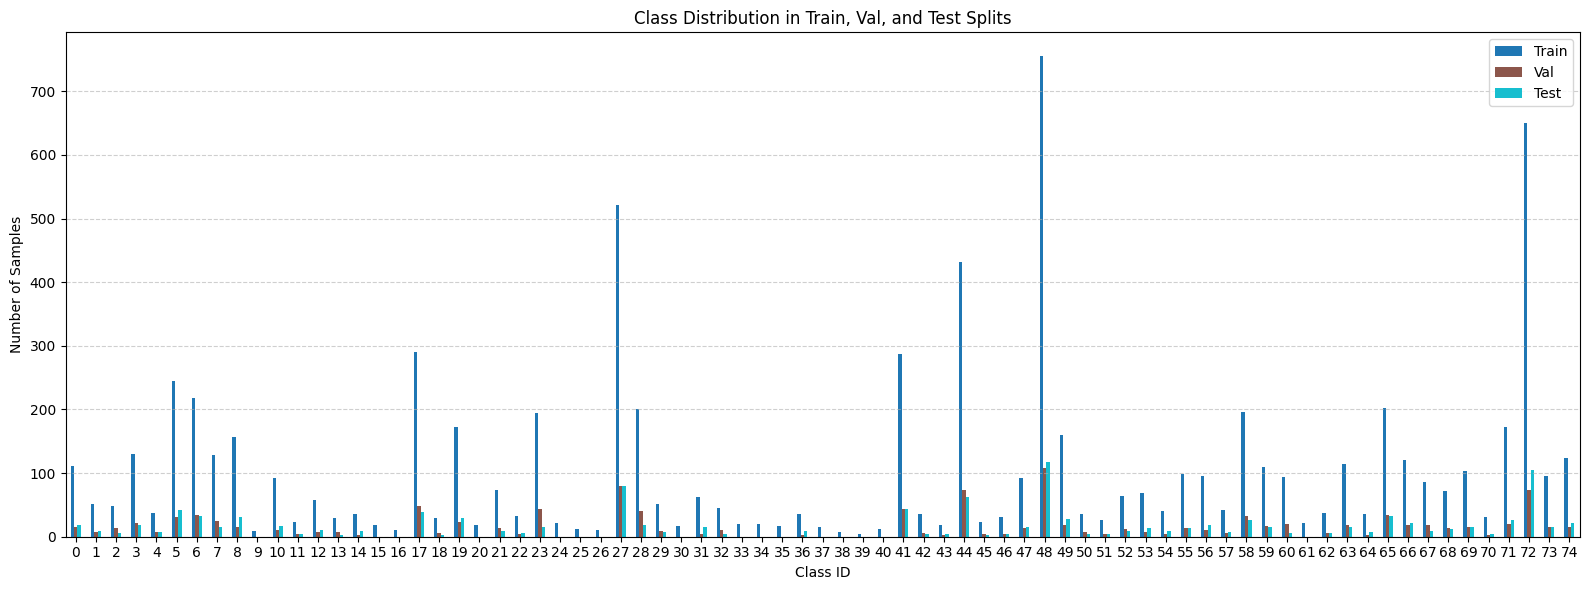

In [6]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# Define label folder paths
label_dirs = {
    'Train': './final_dataset/train/labels',
    'Val': './final_dataset/val/labels',
    'Test': './final_dataset/test/labels'
}

# Count class occurrences for each split
split_counts = {}
for split_name, label_path in label_dirs.items():
    class_counter = Counter()
    for file in os.listdir(label_path):
        if file.endswith('.txt'):
            with open(os.path.join(label_path, file), 'r') as f:
                for line in f:
                    if line.strip():
                        try:
                            class_id = int(line.strip().split()[0])
                            class_counter[class_id] += 1
                        except ValueError:
                            continue
    split_counts[split_name] = class_counter

# Convert to DataFrame
df_dist = pd.DataFrame(split_counts).fillna(0).astype(int)
df_dist.index.name = 'Class ID'
df_dist = df_dist.sort_index()

# Plotting
plt.figure(figsize=(16, 6))
df_dist.plot(kind='bar', figsize=(16, 6), colormap='tab10')
plt.title('Class Distribution in Train, Val, and Test Splits')
plt.xlabel('Class ID')
plt.ylabel('Number of Samples')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [7]:
import pandas as pd

# Load class names from your Excel file
df = pd.read_csv('/content/dataset/Main/label_frequencies.xlsx - Label Frequencies.csv')

# Drop "Total" column and row if present
df = df.drop(columns=['Total'], errors='ignore')
df = df[df['Label'].str.lower() != 'total']

# Generate the 'names' YAML section
print("names:")
for idx, name in enumerate(df['Label']):
    print(f"  {idx}: {name}")


names:
  0: APR-09
  1: APR-10
  2: APR-11
  3: APR-12
  4: APR-14
  5: DWS-01
  6: DWS-02
  7: DWS-03
  8: DWS-04
  9: DWS-09
  10: DWS-10
  11: DWS-11
  12: DWS-12
  13: DWS-13
  14: DWS-14
  15: DWS-15
  16: DWS-16
  17: DWS-17
  18: DWS-18
  19: DWS-19
  20: DWS-20
  21: DWS-21
  22: DWS-25
  23: DWS-26
  24: DWS-27
  25: DWS-28
  26: DWS-29
  27: DWS-32
  28: DWS-33
  29: DWS-35
  30: DWS-36
  31: DWS-40
  32: DWS-41
  33: DWS-42
  34: DWS-44
  35: DWS-46
  36: MNS-01
  37: MNS-02
  38: MNS-03
  39: MNS-04
  40: MNS-05
  41: MNS-06
  42: MNS-07
  43: MNS-09
  44: OSD-01
  45: OSD-02
  46: OSD-03
  47: OSD-04
  48: OSD-06
  49: OSD-07
  50: OSD-16
  51: OSD-17
  52: OSD-26
  53: PHS-01
  54: PHS-02
  55: PHS-03
  56: PHS-04
  57: PHS-09
  58: PHS-23
  59: PHS-24
  60: PRS-01
  61: PRS-02
  62: RSS-02
  63: SLS-100
  64: SLS-15
  65: SLS-40
  66: SLS-50
  67: SLS-60
  68: SLS-70
  69: SLS-80
  70: TLS-C
  71: TLS-E
  72: TLS-G
  73: TLS-R
  74: TLS-Y


In [8]:
!pip install torch torchvision --extra-index-url https://download.pytorch.org/whl/cu113
!pip install ultralytics

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 129.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 99.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 65.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 39.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 102.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uni

In [9]:
import torch
import torch.nn as nn
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [10]:
import torch
import torch.nn as nn
from ultralytics import YOLO

# Load the pre-trained YOLOv8 model
model = YOLO('yolo12n.pt')  # You can choose other variants like yolov8s.pt, yolov8m.pt, etc.

100%|██████████| 5.34M/5.34M [00:00<00:00, 101MB/s]


In [11]:
from ultralytics import YOLO

# Load the YOLOv12n model (pretrained)
model = YOLO('yolo12n.pt')

# Train the model
model.train(
    data='/content/final_dataset/data.yaml',  # 👈 path to your data.yaml
    epochs=100,                     # number of epochs
    imgsz=640,                      # input image size
    batch=64,                       # experiment name
    verbose=True                   # show training logs
)

Ultralytics 8.3.144 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=64, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/final_dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo12n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pret

100%|██████████| 755k/755k [00:00<00:00, 94.9MB/s]

Overriding model.yaml nc=80 with nc=75

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  2    180864  ultralytics.nn.modules.block.A2C2f           [128, 128, 2, True, 4]        
  7                  -1  1    295424  ultralytic

YOLOv12n summary: 272 layers, 2,595,158 parameters, 2,595,142 gradients, 6.6 GFLOPs

Transferred 640/691 items from pretrained weights
Freezing layer 'model.21.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 324MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3045.4±2056.1 MB/s, size: 650.3 KB)


train: Scanning /content/final_dataset/train/labels... 6143 images, 0 backgrounds, 0 corrupt: 100%|██████████| 6143/6143 [00:03<00:00, 1585.63it/s]


train: New cache created: /content/final_dataset/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3117.9±1684.3 MB/s, size: 586.1 KB)


val: Scanning /content/final_dataset/val/labels... 920 images, 0 backgrounds, 0 corrupt: 100%|██████████| 920/920 [00:00<00:00, 1288.51it/s]


val: New cache created: /content/final_dataset/val/labels.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000127, momentum=0.9) with parameter groups 113 weight(decay=0.0), 120 weight(decay=0.0005), 119 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      12.8G      1.336      6.567     0.9642        142        640: 100%|██████████| 96/96 [01:13<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.79it/s]

                   all        920       1155     0.0291      0.072     0.0236     0.0183



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      12.9G      1.333      5.433     0.9323        129        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.99it/s]

                   all        920       1155      0.513     0.0982      0.061     0.0469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      12.9G      1.265      4.415     0.9265        149        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.98it/s]


                   all        920       1155      0.447      0.214      0.116     0.0905

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      12.9G      1.167      3.667     0.9086        152        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.97it/s]


                   all        920       1155      0.426      0.239      0.182      0.144

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      12.9G       1.13      3.151      0.906        133        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.95it/s]

                   all        920       1155      0.508      0.293      0.236      0.188



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      12.9G      1.068      2.771     0.8952        138        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.03it/s]

                   all        920       1155      0.521      0.355      0.307      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      12.9G      1.047      2.496     0.8908        137        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.97it/s]

                   all        920       1155      0.517       0.39      0.347      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      12.9G      1.017      2.261     0.8874        136        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.96it/s]

                   all        920       1155      0.537      0.415      0.372      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      12.9G      1.015      2.141     0.8867        164        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.96it/s]

                   all        920       1155      0.521      0.426      0.398       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100        13G     0.9968      1.969     0.8867        125        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.95it/s]

                   all        920       1155      0.575      0.465      0.444      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100        13G     0.9864      1.858     0.8838        136        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.01it/s]

                   all        920       1155      0.585      0.448      0.461      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100        13G     0.9601       1.73     0.8782        128        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.99it/s]

                   all        920       1155      0.686      0.453      0.493      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100        13G     0.9708       1.65     0.8778        168        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.01it/s]

                   all        920       1155      0.703      0.477      0.503      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      12.9G     0.9515      1.547     0.8784        134        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.96it/s]

                   all        920       1155      0.716      0.503      0.534      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100        13G     0.9321      1.447      0.876        145        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.95it/s]


                   all        920       1155       0.74      0.486       0.54       0.44

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      12.9G      0.925      1.389     0.8732        147        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.94it/s]

                   all        920       1155      0.682      0.464      0.541      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      12.9G     0.9372      1.363     0.8724        148        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.90it/s]


                   all        920       1155      0.651      0.544      0.574      0.463

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100        13G     0.9206      1.309     0.8735        155        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.90it/s]


                   all        920       1155      0.666      0.521      0.579      0.468

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      12.9G     0.9177       1.25     0.8732        115        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.91it/s]


                   all        920       1155      0.658       0.53      0.575      0.462

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      12.9G     0.9133      1.223     0.8691        155        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.97it/s]

                   all        920       1155      0.677      0.541      0.597      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      12.9G     0.8935      1.136     0.8672        140        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.98it/s]

                   all        920       1155      0.747      0.547        0.6      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      12.9G     0.8839      1.132     0.8633        133        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.97it/s]

                   all        920       1155      0.681      0.583      0.621      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      12.9G     0.8809      1.085     0.8607        147        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.95it/s]


                   all        920       1155      0.716      0.571      0.625      0.509

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      12.9G      0.879      1.031     0.8624        152        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.99it/s]

                   all        920       1155      0.739      0.575      0.629      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100        13G     0.8674      1.017     0.8637        131        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.97it/s]

                   all        920       1155      0.751      0.553      0.624      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      12.9G     0.8687      1.007     0.8611        125        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.98it/s]

                   all        920       1155      0.783      0.581      0.655      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100        13G     0.8659     0.9824     0.8619        150        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.97it/s]

                   all        920       1155      0.718      0.599      0.655      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      12.9G     0.8605     0.9527     0.8634        132        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.96it/s]

                   all        920       1155      0.811      0.574      0.665       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      12.9G     0.8483      0.935     0.8572        145        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.99it/s]

                   all        920       1155      0.832      0.589      0.681      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      12.9G     0.8416     0.9085     0.8584        139        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  2.00it/s]

                   all        920       1155      0.848      0.582      0.674      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100        13G      0.846     0.9006     0.8585        152        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.99it/s]

                   all        920       1155      0.786      0.604      0.671      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      12.9G     0.8476     0.8832     0.8545        130        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.98it/s]

                   all        920       1155      0.801      0.583      0.681      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      12.9G     0.8523     0.8804     0.8564        164        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.98it/s]

                   all        920       1155      0.792      0.602      0.673      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100        13G      0.832     0.8489     0.8558        112        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  2.00it/s]

                   all        920       1155      0.799      0.614      0.701      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      12.9G     0.8117      0.814     0.8508        123        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.97it/s]

                   all        920       1155      0.833      0.612       0.69      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      12.9G     0.8119     0.8117     0.8491        159        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.96it/s]

                   all        920       1155      0.825      0.626      0.704       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100        13G     0.8142     0.8037     0.8487        136        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.98it/s]

                   all        920       1155      0.805      0.612      0.704      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      12.8G     0.8182     0.7914     0.8526        151        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.96it/s]

                   all        920       1155      0.849       0.63      0.716      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      12.9G      0.826     0.7942     0.8545        115        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.94it/s]


                   all        920       1155      0.832      0.619      0.708      0.572

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      12.9G     0.8121     0.7713     0.8517        142        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.91it/s]

                   all        920       1155      0.826      0.624      0.723      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100        13G     0.7985     0.7637     0.8474        125        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.96it/s]


                   all        920       1155      0.848      0.624       0.73      0.583

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      12.9G     0.8232     0.7709     0.8517        114        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.93it/s]

                   all        920       1155      0.785      0.653       0.72      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      12.9G     0.7993     0.7475     0.8488        129        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.96it/s]


                   all        920       1155      0.786       0.67      0.735      0.584

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      12.9G     0.7873     0.7345      0.845        123        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.99it/s]

                   all        920       1155      0.791      0.649      0.732      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      12.9G     0.7954     0.7363     0.8452        142        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.96it/s]

                   all        920       1155      0.798      0.675       0.74       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      12.9G     0.7874     0.7206     0.8472        147        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.99it/s]

                   all        920       1155      0.801      0.691      0.759      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      12.9G     0.7867     0.7096      0.843        138        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  2.00it/s]

                   all        920       1155      0.845       0.66      0.752      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      12.9G     0.7867      0.701     0.8451        183        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.98it/s]

                   all        920       1155      0.838      0.662      0.761       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      12.9G     0.7824     0.7062     0.8429        153        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.02it/s]

                   all        920       1155      0.777      0.697      0.758      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      12.9G     0.7698     0.6864     0.8416        142        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.98it/s]

                   all        920       1155      0.819      0.683      0.764      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      12.9G     0.7558     0.6645     0.8403        145        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.96it/s]


                   all        920       1155      0.817      0.661      0.742      0.594

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      12.9G     0.7796     0.6795     0.8434        134        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.96it/s]


                   all        920       1155      0.783        0.7       0.76      0.604

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      12.9G     0.7733     0.6698     0.8416        143        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.97it/s]

                   all        920       1155      0.873      0.641      0.753      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      12.9G       0.76     0.6582     0.8382        133        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.99it/s]

                   all        920       1155       0.76      0.711      0.766      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      12.9G     0.7536     0.6561     0.8393        135        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.00it/s]

                   all        920       1155      0.813      0.697      0.761      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      12.9G     0.7652     0.6563     0.8381        121        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.97it/s]

                   all        920       1155      0.793      0.728      0.779      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100        13G     0.7454     0.6363     0.8356        162        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.97it/s]


                   all        920       1155       0.87      0.639       0.76      0.598

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      12.9G      0.759     0.6499     0.8392        139        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.91it/s]


                   all        920       1155      0.845      0.677      0.765      0.611

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      12.9G     0.7604     0.6418     0.8401        128        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.89it/s]

                   all        920       1155      0.807      0.681      0.757      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      12.9G     0.7525     0.6249     0.8376        133        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.91it/s]

                   all        920       1155      0.839      0.674      0.772       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100        13G     0.7335     0.6123     0.8353        175        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.94it/s]

                   all        920       1155      0.797      0.706      0.775      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      12.9G     0.7464     0.6275     0.8379        158        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.99it/s]

                   all        920       1155      0.797      0.727       0.78      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100        13G     0.7493     0.6311     0.8366        132        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.98it/s]

                   all        920       1155      0.793      0.717      0.774      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      12.9G     0.7346     0.6151     0.8356        133        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.96it/s]

                   all        920       1155      0.776      0.707      0.777      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      12.9G     0.7339     0.6099     0.8351        145        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.96it/s]

                   all        920       1155      0.812      0.709      0.779      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      12.9G     0.7377     0.6103     0.8344        144        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.99it/s]

                   all        920       1155       0.82      0.701      0.774      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      12.9G     0.7279     0.6016     0.8327        145        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.98it/s]

                   all        920       1155      0.777      0.701      0.768      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      12.9G     0.7321      0.598      0.832        118        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.99it/s]

                   all        920       1155      0.776      0.718      0.782      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      12.9G     0.7366     0.6006     0.8348        146        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.99it/s]


                   all        920       1155      0.868      0.663      0.782      0.623

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      12.9G     0.7284      0.595     0.8324        140        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.99it/s]

                   all        920       1155      0.841      0.694      0.776      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      12.9G     0.7082     0.5728     0.8299        159        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.96it/s]

                   all        920       1155      0.778       0.73      0.781      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      12.8G     0.7148     0.5798     0.8288        153        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.94it/s]

                   all        920       1155      0.841      0.719      0.787      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100        13G     0.7146     0.5787     0.8285        113        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.98it/s]

                   all        920       1155      0.818      0.725      0.791      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      12.9G     0.7107     0.5706     0.8311        144        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.00it/s]

                   all        920       1155      0.844      0.698      0.785      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      12.9G     0.7245     0.5876     0.8309        150        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.99it/s]

                   all        920       1155      0.826        0.7      0.789      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100        13G     0.7136     0.5747     0.8332        139        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.02it/s]


                   all        920       1155      0.793      0.724      0.788      0.632

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      12.9G     0.7067     0.5681     0.8281        140        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.01it/s]

                   all        920       1155      0.814      0.717      0.791      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      12.9G     0.7023     0.5551      0.827        118        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  2.00it/s]

                   all        920       1155      0.825      0.721      0.794      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      12.8G     0.7129     0.5687     0.8326        121        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.01it/s]

                   all        920       1155      0.841      0.721        0.8      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      12.8G      0.703      0.556     0.8297        134        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.90it/s]


                   all        920       1155      0.833      0.735      0.804      0.641

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100        13G     0.7004     0.5595     0.8273        150        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.96it/s]

                   all        920       1155      0.825      0.729      0.803       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      12.9G     0.6941     0.5438     0.8264        152        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.99it/s]

                   all        920       1155      0.823      0.726      0.801      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      12.9G     0.6995     0.5538     0.8246        148        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.95it/s]

                   all        920       1155      0.833      0.725      0.803      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      12.9G     0.6876     0.5387     0.8265        141        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.01it/s]

                   all        920       1155      0.844      0.731      0.802      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      12.9G     0.6991     0.5491     0.8246        151        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.99it/s]

                   all        920       1155      0.857      0.724      0.807       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      12.9G      0.679     0.5329     0.8254        139        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.98it/s]

                   all        920       1155      0.835       0.73      0.804      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100        13G      0.689     0.5444     0.8257        133        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.01it/s]

                   all        920       1155      0.835      0.729      0.802      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      12.9G     0.6804     0.5374     0.8252        120        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.97it/s]

                   all        920       1155      0.858      0.727      0.807      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100        13G     0.6796     0.5301     0.8237        151        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.96it/s]


                   all        920       1155      0.856      0.724      0.806      0.645

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      12.9G     0.6862      0.539      0.825        135        640: 100%|██████████| 96/96 [01:06<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.95it/s]

                   all        920       1155      0.839      0.741      0.805      0.642


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      12.8G      0.702     0.5599      0.834         86        640: 100%|██████████| 96/96 [01:09<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.01it/s]

                   all        920       1155      0.814      0.742      0.798      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      12.8G     0.6659     0.5074     0.8292         78        640: 100%|██████████| 96/96 [01:05<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.97it/s]

                   all        920       1155      0.823      0.716      0.792      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      12.8G     0.6571     0.5011     0.8253         81        640: 100%|██████████| 96/96 [01:05<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.98it/s]

                   all        920       1155      0.831      0.733        0.8       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      12.8G     0.6536     0.4894     0.8223         70        640: 100%|██████████| 96/96 [01:05<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.98it/s]

                   all        920       1155      0.833      0.732      0.802      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      12.8G     0.6484     0.4862     0.8238         69        640: 100%|██████████| 96/96 [01:05<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.97it/s]


                   all        920       1155      0.826       0.74      0.804      0.639

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      12.9G       0.64     0.4798     0.8225         89        640: 100%|██████████| 96/96 [01:05<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.88it/s]

                   all        920       1155      0.826      0.747      0.807      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      12.9G     0.6465     0.4834     0.8212         82        640: 100%|██████████| 96/96 [01:05<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.98it/s]

                   all        920       1155       0.83      0.743      0.809      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      12.8G     0.6444     0.4882     0.8181         70        640: 100%|██████████| 96/96 [01:05<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.95it/s]

                   all        920       1155      0.833      0.744      0.806      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      12.8G     0.6453      0.483     0.8238         69        640: 100%|██████████| 96/96 [01:05<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.97it/s]

                   all        920       1155      0.835      0.744      0.804      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      12.8G     0.6322     0.4724     0.8196         78        640: 100%|██████████| 96/96 [01:05<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.99it/s]

                   all        920       1155      0.833      0.747      0.808      0.647



100 epochs completed in 1.977 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 5.6MB
Optimizer stripped from runs/detect/train/weights/best.pt, 5.6MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.144 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
YOLOv12n summary (fused): 159 layers, 2,583,739 parameters, 0 gradients, 6.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.66it/s]


                   all        920       1155      0.833      0.747      0.808      0.647
                APR-09         15         15      0.687      0.667      0.731      0.524
                APR-10          7          7      0.833      0.712      0.906      0.771
                APR-11         13         13      0.965      0.923       0.99      0.735
                APR-12         21         21      0.774       0.81      0.828      0.669
                APR-14          8          8       0.82       0.75      0.871      0.557
                DWS-01         31         31      0.953          1      0.992      0.886
                DWS-02         34         34      0.927      0.941      0.976      0.887
                DWS-03         24         24      0.984          1      0.995      0.897
                DWS-04         16         16      0.838      0.938      0.978      0.898
                DWS-10         11         11          1      0.957      0.995      0.774
                DWS-1

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 14, 17, 18, 19, 21, 22, 23, 27, 28, 29, 31, 32, 36, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7fb529486310>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031

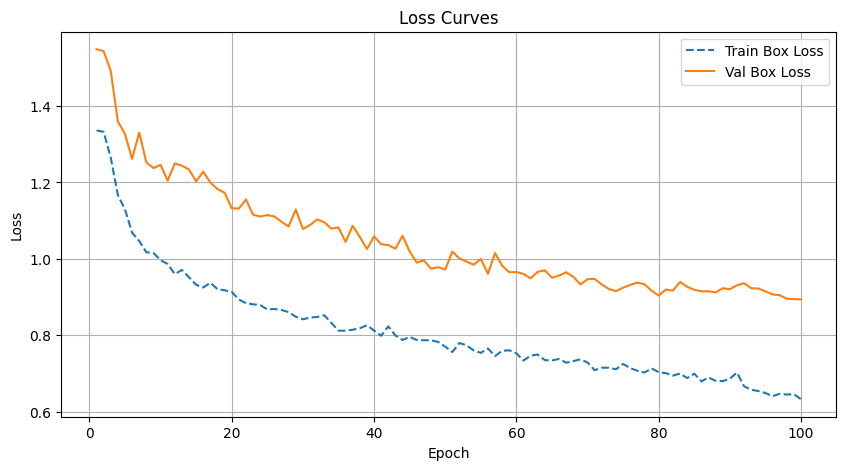

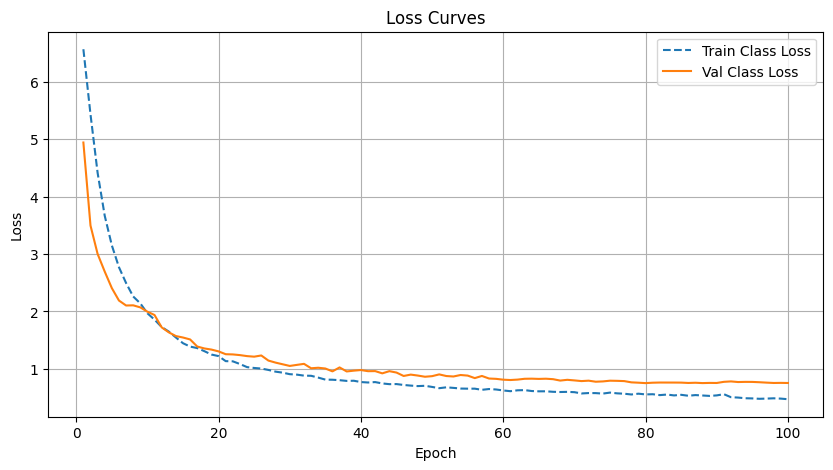

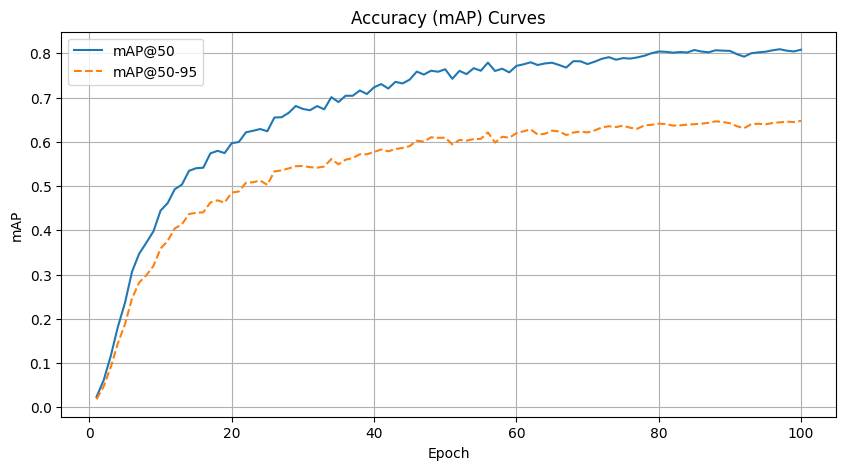

In [13]:
# Load the CSV file
results_path = "/content/runs/detect/train/results.csv"  # Update path if needed
df = pd.read_csv(results_path)

# Remove extra spaces from column names
df.columns = df.columns.str.strip()

# Now, plot the curves
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(df['epoch'], df['train/box_loss'], label='Train Box Loss', linestyle='dashed')
plt.plot(df['epoch'], df['val/box_loss'], label='Val Box Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()
plt.grid()
plt.show()

print("     ")
plt.figure(figsize=(10, 5))
plt.plot(df['epoch'], df['train/cls_loss'], label='Train Class Loss', linestyle='dashed')
plt.plot(df['epoch'], df['val/cls_loss'], label='Val Class Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()
plt.grid()
plt.show()

print("     ")
# Plot mAP Accuracy Curves
plt.figure(figsize=(10, 5))
plt.plot(df['epoch'], df['metrics/mAP50(B)'], label='mAP@50')
plt.plot(df['epoch'], df['metrics/mAP50-95(B)'], label='mAP@50-95', linestyle='dashed')
plt.xlabel('Epoch')
plt.ylabel('mAP')
plt.title('Accuracy (mAP) Curves')
plt.legend()
plt.grid()
plt.show()

In [14]:
results = model.val()
print(results)

Ultralytics 8.3.144 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
YOLOv12n summary (fused): 159 layers, 2,583,739 parameters, 0 gradients, 6.5 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3486.6±1489.3 MB/s, size: 714.2 KB)


val: Scanning /content/final_dataset/val/labels.cache... 920 images, 0 backgrounds, 0 corrupt: 100%|██████████| 920/920 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [00:08<00:00,  1.68it/s]


                   all        920       1155      0.832      0.748      0.808      0.648
                APR-09         15         15      0.684      0.667      0.733      0.524
                APR-10          7          7      0.833      0.712      0.906      0.771
                APR-11         13         13      0.964      0.923       0.99      0.719
                APR-12         21         21      0.772       0.81      0.828      0.666
                APR-14          8          8      0.818       0.75      0.871      0.557
                DWS-01         31         31      0.953          1      0.992      0.894
                DWS-02         34         34      0.927      0.941      0.977      0.888
                DWS-03         24         24      0.981          1      0.995      0.892
                DWS-04         16         16      0.839      0.938      0.982      0.901
                DWS-10         11         11          1      0.958      0.995      0.802
                DWS-1

In [16]:
from thop import profile
from ultralytics import YOLO
import torch

# ✅ Load model properly
model = YOLO('/content/runs/detect/train/weights/best.pt')
torch_model = model.model  # Raw nn.Module

# ✅ Create dummy input
device = 'cuda' if torch.cuda.is_available() else 'cpu'
input_tensor = torch.randn(1, 3, 640, 640).to(device)

# ✅ Move model to same device
torch_model = torch_model.to(device)

# ✅ Profile
macs, params = profile(torch_model, inputs=(input_tensor,), verbose=False)

# ✅ Print results
print(f"Params: {params / 1e6:.2f} Million")
print(f"MACs: {macs / 1e9:.2f} GMACs")
print(f"FLOPs: {2 * macs / 1e9:.2f} GFLOPs (approx)")

Params: 2.60 Million
MACs: 3.31 GMACs
FLOPs: 6.62 GFLOPs (approx)


In [17]:
from ultralytics import YOLO

# Load your trained YOLOv8n model
model = YOLO('/content/runs/detect/train/weights/best.pt')  # change path if needed

# Evaluate on validation set
metrics = model.val()

Ultralytics 8.3.144 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
YOLOv12n summary (fused): 159 layers, 2,583,739 parameters, 0 gradients, 6.5 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 4920.8±1230.3 MB/s, size: 641.5 KB)


val: Scanning /content/final_dataset/val/labels.cache... 920 images, 0 backgrounds, 0 corrupt: 100%|██████████| 920/920 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 58/58 [00:13<00:00,  4.40it/s]


                   all        920       1155      0.832      0.748      0.808      0.648
                APR-09         15         15      0.684      0.667      0.733      0.524
                APR-10          7          7      0.833      0.712      0.906      0.771
                APR-11         13         13      0.964      0.923       0.99      0.719
                APR-12         21         21      0.772       0.81      0.828      0.666
                APR-14          8          8      0.818       0.75      0.871      0.557
                DWS-01         31         31      0.953          1      0.992      0.891
                DWS-02         34         34      0.927      0.941      0.977      0.888
                DWS-03         24         24      0.981          1      0.995      0.892
                DWS-04         16         16      0.839      0.938      0.982      0.901
                DWS-10         11         11          1      0.958      0.995      0.788
                DWS-1

In [18]:
# Extract metrics from `metrics.box`
precision = metrics.box.p.mean()       # mean precision
recall = metrics.box.r.mean()          # mean recall
map50 = metrics.box.ap50.mean()        # mAP@0.5
map5095 = metrics.box.ap.mean()        # mAP@0.5:0.95

# Calculate F1-score
f1_score = 2 * (precision * recall) / (precision + recall + 1e-6)

# Print summary
print("\n✅ 📊 Overall Evaluation Summary:")
print(f"{'Metric':<15} | {'Value':>8}")
print(f"{'-'*26}")
print(f"{'mAP@50':<15} | {map50:.3f}")
print(f"{'mAP@50-95':<15} | {map5095:.3f}")
print(f"{'Precision':<15} | {precision:.3f}")
print(f"{'Recall':<15} | {recall:.3f}")
print(f"{'F1-Score':<15} | {f1_score:.3f}")


✅ 📊 Overall Evaluation Summary:
Metric          |    Value
--------------------------
mAP@50          | 0.808
mAP@50-95       | 0.648
Precision       | 0.832
Recall          | 0.748
F1-Score        | 0.788


In [19]:
import time

# Load model
model = YOLO('/content/runs/detect/train/weights/best.pt')

# Prepare input
img_path = '/content/sign4.jpg'

# Time the inference
start = time.time()
results = model.predict(source=img_path, imgsz=640)
end = time.time()

# FPS calculation
elapsed = end - start
fps = 1 / elapsed
print(f"\n🕒 Elapsed Time: {elapsed:.4f} sec")
print(f"🎯 FPS: {fps:.2f}")


image 1/1 /content/sign4.jpg: 640x480 1 DWS-04, 96.2ms
Speed: 3.0ms preprocess, 96.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)

🕒 Elapsed Time: 0.3135 sec
🎯 FPS: 3.19


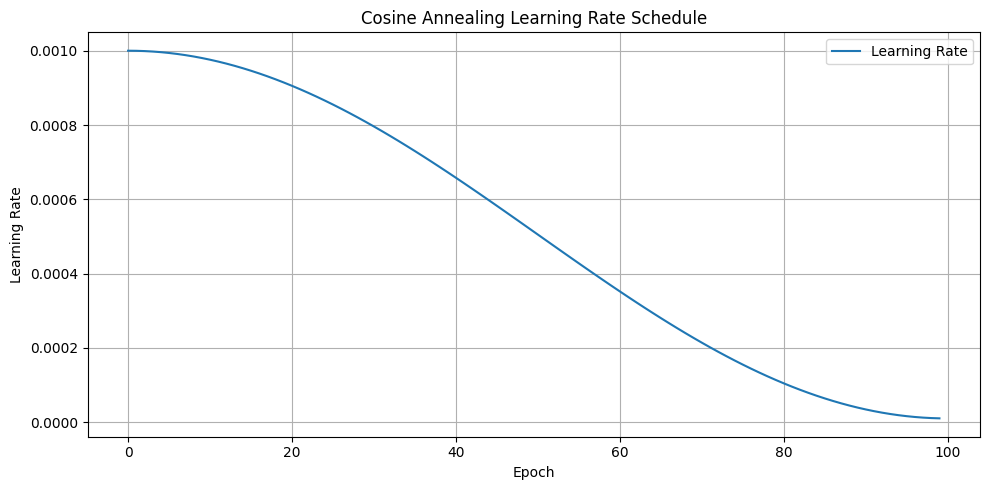

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# Simulate a cosine annealing schedule for learning rate
def cosine_annealing_schedule(lr0, lrf, epochs):
    return [lrf + 0.5 * (lr0 - lrf) * (1 + np.cos(np.pi * epoch / epochs)) for epoch in range(epochs)]

# Define parameters
lr0 = 0.001       # initial learning rate
lrf = 0.00001     # final learning rate
epochs = 100      # total training epochs

# Generate schedule
lr_schedule = cosine_annealing_schedule(lr0, lrf, epochs)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(range(epochs), lr_schedule, label="Learning Rate")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Cosine Annealing Learning Rate Schedule")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

<ipython-input-21-850f16860bb0>:25: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


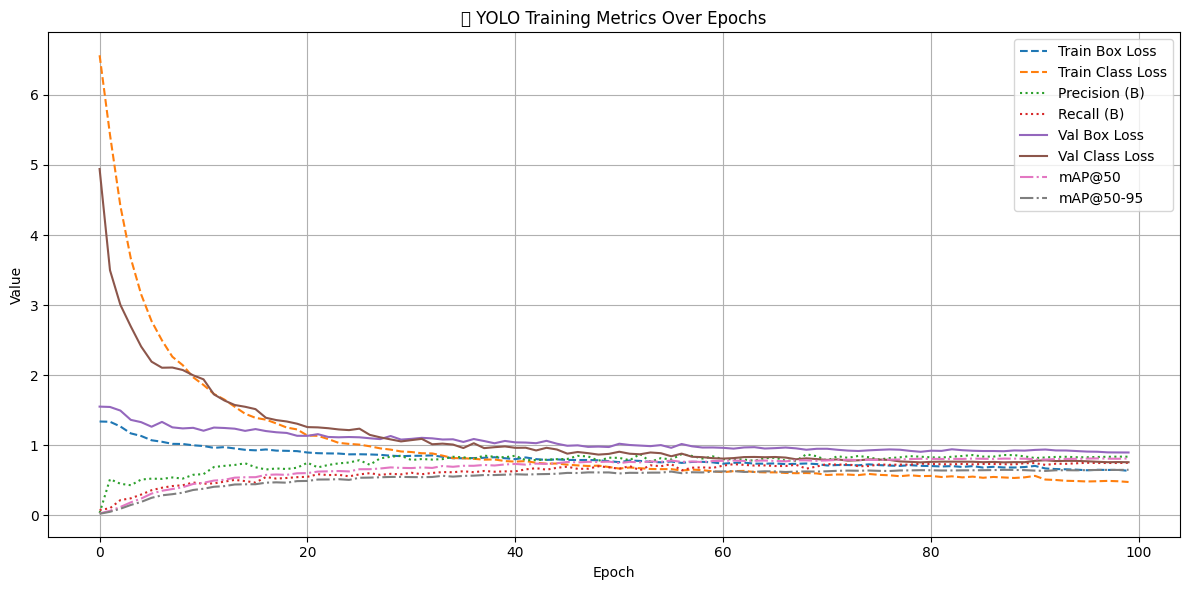

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# === STEP 1: Load the results.csv ===
# Replace with your path to YOLO training logs
csv_path = '/content/runs/detect/train/results.csv'  # or 'runs/train/yolo12n_final_tuned/results.csv'
df = pd.read_csv(csv_path)

# === STEP 2: Plot Loss Curves ===
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['train/box_loss'], label='Train Box Loss', linestyle='--')
plt.plot(df.index, df['train/cls_loss'], label='Train Class Loss', linestyle='--')
plt.plot(df.index, df['metrics/precision(B)'], label='Precision (B)', linestyle=':')
plt.plot(df.index, df['metrics/recall(B)'], label='Recall (B)', linestyle=':')
plt.plot(df.index, df['val/box_loss'], label='Val Box Loss')
plt.plot(df.index, df['val/cls_loss'], label='Val Class Loss')
plt.plot(df.index, df['metrics/mAP50(B)'], label='mAP@50', linestyle='-.')
plt.plot(df.index, df['metrics/mAP50-95(B)'], label='mAP@50-95', linestyle='-.')

plt.title("📊 YOLO Training Metrics Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
